In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

In [2]:
img1 = cv2.imread("grains1.jpg")
img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

In [3]:
pixels_to_um = 0.5 # 1 pixel = 500 nm (got this from the metadata of original image)


In [5]:
# ret1, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
ret1, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2.imshow('Colored Grains', thresh)
cv2.waitKey(0)

-1

In [6]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
cv2.imshow('Colored Grains',opening )
cv2.waitKey(0)


-1

In [ ]:
# from skimage.segmentation import clear_border
# opening = clear_border(opening) 

In [7]:
sure_bg = cv2.dilate(opening,kernel,iterations=2)
cv2.imshow('Colored Grains',sure_bg )
cv2.waitKey(0)

-1

In [8]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
cv2.imshow('Colored Grains',dist_transform)
cv2.waitKey(0)

-1

In [9]:
ret2, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)

In [10]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
cv2.imshow('Colored Grains', unknown)
cv2.waitKey(0)

-1

In [11]:
ret3, markers = cv2.connectedComponents(sure_fg)


In [12]:
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [13]:
markers = cv2.watershed(img1,markers)

In [14]:
img1[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

cv2.imshow('Overlay on original image', img1)
cv2.imshow('Colored Grains', img2)
cv2.waitKey(0)


-1

In [15]:
regions = measure.regionprops(markers, intensity_image=img)


In [16]:
#Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

#Best way is to output all properties to a csv file
#Let us pick which ones we want to export. 

# propList = ['Area',
            # 'equivalent_diameter', #Added... verify if it works
            # 'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            # 'MajorAxisLength',
            # 'MinorAxisLength',
            # 'Perimeter',
            # 'MinIntensity',
            # 'MeanIntensity',
            # 'MaxIntensity']    
    


Label: 10 Area: 38126.0
Label: 11 Area: 270.0
Label: 12 Area: 74.0
Label: 13 Area: 81.0
Label: 14 Area: 35.0
Label: 15 Area: 534.0
Label: 16 Area: 62.0
Label: 17 Area: 444.0
Label: 18 Area: 430.0
Label: 19 Area: 103.0
Label: 20 Area: 85.0
Label: 21 Area: 91.0
Label: 22 Area: 318.0
Label: 23 Area: 159.0
Label: 24 Area: 151.0
Label: 25 Area: 66.0
Label: 26 Area: 69.0
Label: 27 Area: 162.0
Label: 28 Area: 88.0
Label: 29 Area: 231.0
Label: 30 Area: 140.0
Label: 31 Area: 99.0
Label: 32 Area: 147.0
Label: 33 Area: 180.0
Label: 34 Area: 94.0
Label: 35 Area: 95.0
Label: 36 Area: 100.0
Label: 37 Area: 59.0
Label: 38 Area: 65.0
Label: 39 Area: 240.0
Label: 40 Area: 384.0
Label: 41 Area: 40.0
Label: 42 Area: 53.0
Label: 43 Area: 275.0
Label: 44 Area: 138.0
Label: 45 Area: 83.0
Label: 46 Area: 290.0
Label: 47 Area: 126.0
Label: 48 Area: 80.0
Label: 49 Area: 245.0
Label: 50 Area: 107.0
Label: 51 Area: 65.0
Label: 52 Area: 132.0
Label: 53 Area: 144.0
Label: 54 Area: 282.0
Label: 55 Area: 90.0
Label:

In [17]:
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

In [18]:
output_file = open('image_measurements.csv', 'w')
output_file.write('Grain #' + "," + "," + ",".join(propList) + '\n') #join strings in array by commas, 
#First cell to print grain number
#Second cell blank as we will not print Label column

grain_number = 1
for region_props in regions:
    output_file.write(str(grain_number) + ',')
    #output cluster properties to the excel file
#    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels_to_um
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
    grain_number += 1
    
output_file.close()   #Closes the file, otherwise it would be read only. 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
data=pd.read_csv("image_measurements.csv")
data.head()

,Grain #,Unnamed: 1,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter,MinIntensity,MeanIntensity,MaxIntensity
0,1,NaN,9531.50,110.162983,84.172789,182.994759,142.225502,4166.742656,6.0,86.684887,255.0
1,2,NaN,67.50,9.270581,-7.396922,11.136632,7.995843,31.071068,150.0,195.003704,216.0
2,3,NaN,18.50,4.853342,-89.696824,5.851375,4.204103,16.071068,80.0,172.581081,198.0
3,4,NaN,20.25,5.077706,87.705638,7.106784,3.786798,16.949747,152.0,181.172840,203.0
4,5,NaN,8.75,3.337791,86.555435,5.342336,2.128489,10.914214,57.0,176.571429,197.0


In [21]:
Area =data["Area"]

Text(0.5, 1.0, 'Histogram of Particle Area')

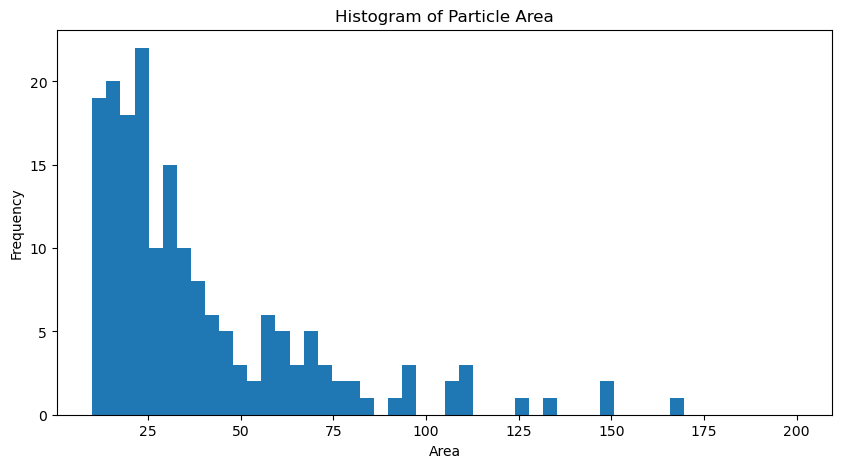

In [26]:
plt.figure(figsize=(10,5))
plt.hist(Area, bins=50, range=(10, 200))  # Set the x-axis range to (10, 100)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Histogram of Particle Area')